In [99]:
# How motor-y are pmns?
import utils_EL as ut
import pandas as pd
import numpy as np
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
from caveclient import CAVEclient
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import cmocean
import os

In [100]:
client = CAVEclient()
if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [306]:
premotor_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/wingpremotor072022.csv')
local_df = premotor_df[premotor_df['class'].isin(['local'])]
local_df['notes'].value_counts()[118:140]


Series([], Name: notes, dtype: int64)

In [307]:
local_df

,SegID,class,notes,notes1
0,648518346477519118,local,0,0 t2
1,648518346480952410,local,0,0 t2
2,648518346492576699,local,0,0 t2
3,648518346474380994,local,0,0 t2
4,648518346488918761,local,0,0 t2
...,...,...,...,...
1551,648518346484021277,local,NaN,u3T
1552,648518346480381142,local,NaN,u3U
1553,648518346487320746,local,NaN,u3V
1554,648518346497811815,local,NaN,u3W


In [128]:
ACh_list = ['1A t1', '7B t2', '7B t3', '8B', '11A t2', '12A t2', '17A t2', '17A t3', '18B t3', '19Bb t2', '19Bb t3', '19Ba t2', '18B t2', '7Bd t2', '1A t2', '3A?', '19B t1', '20A t2', '18B?', '3A', '8B t3', '12A', '11A?', '8B?', '8B t2', '7B t1', 'PSI']
GABA_list = ['1B?', '3B t1', '3Bc t2', '3B t3?', '3B t2', '5B?', '6A', '6B', '11B t2', '6B t3', '6B?', '0 t2', '3Ba t1', '13B?', '3B?', '3Bb t1', '6A?', '12B', '3Ba t2', '6A t2', '11B? t2', '3B', '5B', '6A t3', '12B?', '11B?']
Glu_list = ['2A', '8A', '8A?', '16B t2', '21A?', '21A? t2', '2A t3', '16B t3']



In [129]:
ACh_df = local_df[local_df['notes'].isin(ACh_list)]
len(ACh_df)

459

In [130]:
GABA_df = local_df[local_df['notes'].isin(GABA_list)]
len(GABA_df)

458

In [131]:
Glu_df = local_df[local_df['notes'].isin(Glu_list)]
len(Glu_df)

78

In [132]:
OtherNT_df = local_df[~local_df['notes'].isin(ACh_list + GABA_list + Glu_list)]
len(OtherNT_df)

269

In [274]:
twigIDs = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/alltwigs_0512.csv')
MN_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/MNs_EL_040622.csv')
leftMN_df = MN_df[MN_df.side.isin(['L'])]
leftMN_df = leftMN_df[~leftMN_df.SegID.isin([648518346486137513])] # PSI
len(leftMN_df)

34

In [11]:
# divide PMNs according to csv
premotor_df = pd.read_csv('/Users/ellenlesser/Desktop/pmn_env/CSVs/premotor_df0702.csv')
local_df = premotor_df[premotor_df['class'].isin(['local'])]
ascending_df = premotor_df[premotor_df['class'].isin(['ascending'])]
sensory_df = premotor_df[premotor_df['class'].isin(['sensory'])]
descending_df = premotor_df[premotor_df['class'].isin(['descending'])]
fragment_df = premotor_df[premotor_df['class'].isin(['fragment'])]
other_pmn_df = premotor_df[~premotor_df['class'].isin(['local','ascending','sensory','descending'])]
pmn_not_noise_df = premotor_df[~premotor_df.SegID.isin(MN_df.SegID.to_list())]

In [133]:
# Designate which neuron(s) to query
# output if segIDs have no partners - means the ID is out of date

thresh_syn = 3 # minimum synapse threshold to be considered a partner
prepost = "post" # "pre" to find presynaptic partners, "post" to find postsynaptic partners
query_list = local_df.SegID.to_list()

#syn_df = ut.build_synapse_df(query_list,prepost,thresh_syn,client) 
postcounts = pd.DataFrame(syn_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))
precounts = pd.DataFrame(syn_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

synapse_df = syn_df[~syn_df.pre_pt_root_id.isin(twigIDs.SegID.to_list())]

if precounts.shape[0] != len(query_list):
    print('Warning: The following segIDs are not up to date')
    print(list(set(query_list) - set(precounts['SegID'])))

In [134]:
precounts

,SegID,counts
0,648518346494696355,14659
1,648518346517344554,11163
2,648518346489656701,8476
3,648518346499338078,8190
4,648518346487473834,7795
...,...,...
1259,648518346490370826,43
1260,648518346520525622,43
1261,648518346494443797,42
1262,648518346472332747,39


In [310]:
# horizontal bar, one for each pmn
counts_syn = precounts
this_syn_df = syn_df

counts_syn['mn'] = ''
# counts_syn['local'] = ''
# counts_syn['ascending'] = ''
# counts_syn['sensory'] = ''
# counts_syn['descending'] = ''
# counts_syn['fragment'] = ''
counts_syn['pmn'] = ''
counts_syn['other'] = ''

i = 0
while i < len(counts_syn):
    pmn_i = counts_syn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    # local_pmns = syn_i[syn_i['post_pt_root_id'].isin(local_df.SegID.to_list())]
    # sensory_pmns = syn_i[syn_i['post_pt_root_id'].isin(sensory_df.SegID.to_list())]
    # ascending_pmns = syn_i[syn_i['post_pt_root_id'].isin(ascending_df.SegID.to_list())]
    # descending_pmns = syn_i[syn_i['post_pt_root_id'].isin(descending_df.SegID.to_list())]
    mn_pmns = syn_i[syn_i['post_pt_root_id'].isin(MN_df.SegID.to_list())]
    # temp1 = syn_i[syn_i['post_pt_root_id'].isin(fragment_df.SegID.to_list())]
    # temp2 = syn_i[syn_i['post_pt_root_id'].isin(twigIDs.SegID.to_list())]
    # fragment_pmns = temp1.append(temp2)
    # otherpmn_pmns = syn_i[syn_i['post_pt_root_id'].isin(other_pmn_df.SegID.to_list())]
    pmn_pmns = syn_i[syn_i['post_pt_root_id'].isin(pmn_not_noise_df.SegID.to_list())]
    not_pmns = syn_i[~syn_i['post_pt_root_id'].isin(pmn_not_noise_df.SegID.to_list() + MN_df.SegID.to_list())]

    counts_syn['mn'].iloc[i] = len(mn_pmns)
    # counts_syn['local'].iloc[i] = len(local_pmns.post_pt_root_id.value_counts())
    # counts_syn['ascending'].iloc[i] = len(ascending_pmns.post_pt_root_id.value_counts())
    # counts_syn['sensory'].iloc[i] = len(sensory_pmns.post_pt_root_id.value_counts())
    # counts_syn['descending'].iloc[i] = len(descending_pmns.post_pt_root_id.value_counts())
    # counts_syn['fragment'].iloc[i] = len(fragment_pmns.post_pt_root_id.value_counts())
    counts_syn['pmn'].iloc[i] = len(pmn_pmns)
    counts_syn['other'].iloc[i] = len(not_pmns)

    i = i+1




/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [43]:
# sensory pmns only
temp_syn_df = synapse_df[synapse_df.pre_pt_root_id.isin(sensory_df.SegID.to_list())]
temp_pmn_df = pd.DataFrame(temp_syn_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

local_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(local_df.SegID.to_list())]
sensory_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(sensory_df.SegID.to_list())]
ascending_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(ascending_df.SegID.to_list())]
descending_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(descending_df.SegID.to_list())]
mn_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(MN_df.SegID.to_list())]
temp1 = temp_pmn_df[temp_pmn_df['SegID'].isin(fragment_df.SegID.to_list())]
temp2 = temp_pmn_df[temp_pmn_df['SegID'].isin(twigIDs.SegID.to_list())]
fragment_pmns = temp1.append(temp2)
otherpmn_pmns = temp_pmn_df[temp_pmn_df['SegID'].isin(other_pmn_df.SegID.to_list())]

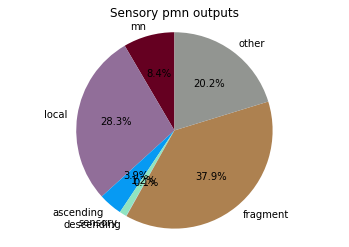

In [46]:
colors = ["#650021", "#916e99","#069af3","#90e4c1","#95d0fc","#ad8150","#929591", "#650021"]
cmap = sns.set_palette(sns.color_palette(colors))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'mn', 'local', 'ascending', 'sensory', 'descending', 'fragment', 'other'
sizes = [sum(mn_pmns.counts), sum(local_pmns.counts), sum(ascending_pmns.counts), sum(sensory_pmns.counts), sum(descending_pmns.counts), sum(fragment_pmns.counts), sum(otherpmn_pmns.counts)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%', labels = labels,
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sensory pmn outputs')

plt.show()

In [334]:
# horizontal bar, one for each pmn
counts_syn = precounts
this_syn_df = syn_df

counts_syn['mn'] = ''
counts_syn['local'] = ''
counts_syn['ascending'] = ''
counts_syn['sensory'] = ''
counts_syn['descending'] = ''
counts_syn['fragment'] = ''
counts_syn['other'] = ''

i = 0
while i < len(counts_syn):
    pmn_i = counts_syn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    local_pmns = syn_i[syn_i['post_pt_root_id'].isin(local_df.SegID.to_list())]
    sensory_pmns = syn_i[syn_i['post_pt_root_id'].isin(sensory_df.SegID.to_list())]
    ascending_pmns = syn_i[syn_i['post_pt_root_id'].isin(ascending_df.SegID.to_list())]
    descending_pmns = syn_i[syn_i['post_pt_root_id'].isin(descending_df.SegID.to_list())]
    mn_pmns = syn_i[syn_i['post_pt_root_id'].isin(MN_df.SegID.to_list())]
    temp1 = syn_i[syn_i['post_pt_root_id'].isin(fragment_df.SegID.to_list())]
    temp2 = syn_i[syn_i['post_pt_root_id'].isin(twigIDs.SegID.to_list())]
    fragment_pmns = temp1.append(temp2)
    otherpmn_pmns = syn_i[syn_i['post_pt_root_id'].isin(other_pmn_df.SegID.to_list())]

    counts_syn['mn'].iloc[i] = len(mn_pmns.post_pt_root_id.value_counts())
    counts_syn['local'].iloc[i] = len(local_pmns.post_pt_root_id.value_counts())
    counts_syn['ascending'].iloc[i] = len(ascending_pmns.post_pt_root_id.value_counts())
    counts_syn['sensory'].iloc[i] = len(sensory_pmns.post_pt_root_id.value_counts())
    counts_syn['descending'].iloc[i] = len(descending_pmns.post_pt_root_id.value_counts())
    counts_syn['fragment'].iloc[i] = len(fragment_pmns.post_pt_root_id.value_counts())
    counts_syn['other'].iloc[i] = len(otherpmn_pmns.post_pt_root_id.value_counts())

    i = i+1




/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


KeyboardInterrupt: 

In [21]:
counts_syn.head()

,SegID,counts,mn,pmn,other
0,648518346494696355,14659,243,1112,13304
1,648518346517344554,11163,19,2660,8484
2,648518346489656701,8476,1274,1113,6089
3,648518346499338078,8190,69,1184,6937
4,648518346487473834,7795,48,577,7170


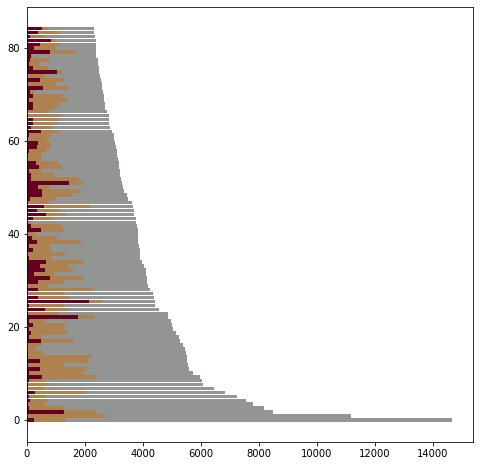

In [25]:
# barh
colors = ["#650021","#c79fef","#929591"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,8])
df = counts_syn[0:100]

xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['mn'])
plt.barh(xn, df['pmn'], left = df['mn'])
plt.barh(xn, df['other'], left = df['pmn'] + df['mn'])

plt.show()

In [136]:
# proportion df
proportion_df = counts_syn.iloc[:,0:1]
proportion_df['mn'] = counts_syn.mn / counts_syn.counts
proportion_df['pmn'] = counts_syn.pmn / counts_syn.counts
proportion_df['other'] = counts_syn.other / counts_syn.counts

proportion_df.head()


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying t

,SegID,mn,pmn,other
0,648518346494696355,0.016577,0.075858,0.907565
1,648518346517344554,0.001702,0.238287,0.760011
2,648518346489656701,0.150307,0.131312,0.718381
3,648518346499338078,0.008425,0.144567,0.847009
4,648518346487473834,0.006158,0.074022,0.91982


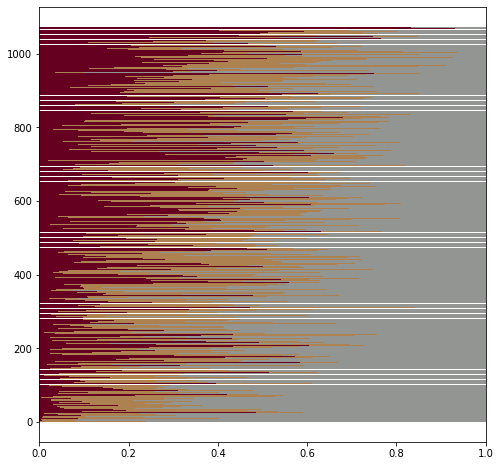

In [31]:
# barh
colors = ["#650021","#c79fef","#929591"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,8])
df = proportion_df

xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['mn'])
plt.barh(xn, df['pmn'], left = df['mn'])
plt.barh(xn, df['other'], left = df['pmn'] + df['mn'])

plt.show()

In [32]:
# break up by hemilineage designation.......
pmn19B_df = local_df[local_df.notes.isin(['19B t1', '19Ba t2', '19Ba?', '19Bb t2', '19Bb t3'])]
pmn17A_df = local_df[local_df.notes.isin(['17A t2','17A t3'])]
pmn12A_df = local_df[local_df.notes.isin(['12A t2'])]
pmn6B_df = local_df[local_df.notes.isin(['6B t2', '6B t3'])]


pmn19B_proportion_df = proportion_df[proportion_df.SegID.isin(pmn19B_df.SegID.to_list())]
pmn17A_proportion_df = proportion_df[proportion_df.SegID.isin(pmn17A_df.SegID.to_list())]
pmn12A_proportion_df = proportion_df[proportion_df.SegID.isin(pmn12A_df.SegID.to_list())]
pmn6B_proportion_df = proportion_df[proportion_df.SegID.isin(pmn6B_df.SegID.to_list())]

remainder_proportion_df = proportion_df[~proportion_df.SegID.isin(pmn19B_df.SegID.to_list() + pmn17A_df.SegID.to_list() + pmn12A_df.SegID.to_list() + pmn6B_df.SegID.to_list())]

print(len(proportion_df))
print(len(remainder_proportion_df) + len(pmn19B_proportion_df) + len(pmn17A_proportion_df) + len(pmn12A_proportion_df) + len(pmn6B_proportion_df))



1264
909
138
81
56
80


In [97]:
len(pmn17A_proportion_df)

81

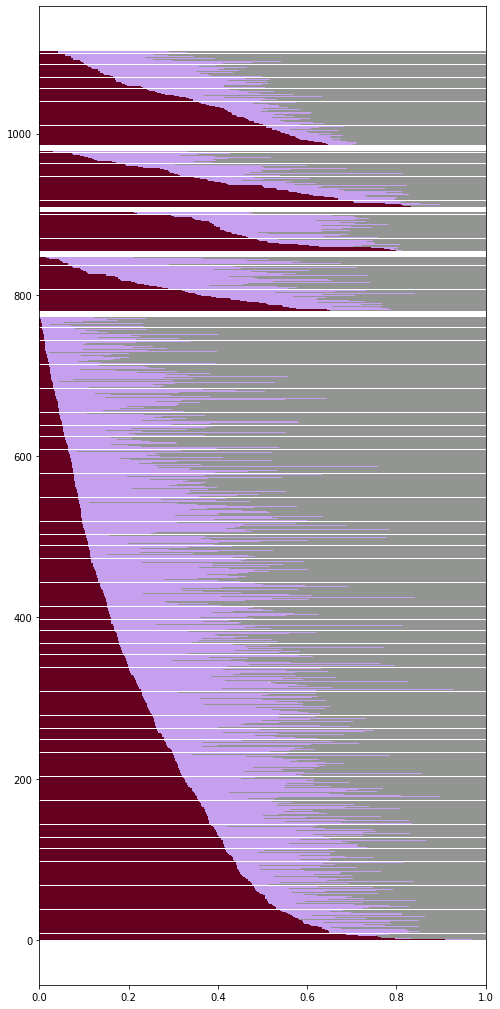

In [96]:
# barh
colors = ["#650021","#c79fef","#929591"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,18])

df = remainder_proportion_df
df = df.sort_values(by = ['mn'], ascending = False)
xn1 = [i for i, _ in enumerate(df['mn'])]
xn1 = np.array(xn1)*0.85
plt.barh(xn1, df['mn'])
plt.barh(xn1, df['pmn'], left = df['mn'])
plt.barh(xn1, df['other'], left = df['pmn'] + df['mn'])

df = pmn6B_proportion_df
df = df.sort_values(by = ['mn'], ascending = False)
xn2 = [i for i, _ in enumerate(df['mn'])]
xn2 = np.array(xn2)*0.85
xn2 = xn2 +max(xn1)+8
plt.barh(xn2, df['mn'])
plt.barh(xn2, df['pmn'], left = df['mn'])
plt.barh(xn2, df['other'], left = df['pmn'] + df['mn'])

df = pmn12A_proportion_df
df = df.sort_values(by = ['mn'], ascending = False)
xn3 = [i for i, _ in enumerate(df['mn'])]
xn3 = np.array(xn3)*0.85
xn3 = xn3 +max(xn2)+8
plt.barh(xn3, df['mn'])
plt.barh(xn3, df['pmn'], left = df['mn'])
plt.barh(xn3, df['other'], left = df['pmn'] + df['mn'])

df = pmn17A_proportion_df
df = df.sort_values(by = ['mn'], ascending = False)
xn4 = [i for i, _ in enumerate(df['mn'])]
xn4 = np.array(xn4)*0.85
xn4 = xn4 +max(xn3)+8
plt.barh(xn4, df['mn'])
plt.barh(xn4, df['pmn'], left = df['mn'])
plt.barh(xn4, df['other'], left = df['pmn'] + df['mn'])

df = pmn19B_proportion_df
df = df.sort_values(by = ['mn'], ascending = False)
xn5 = [i for i, _ in enumerate(df['mn'])]
xn5 = np.array(xn5)*0.85
xn5 = xn5 +max(xn4)+8
plt.barh(xn5, df['mn'])
plt.barh(xn5, df['pmn'], left = df['mn'])
plt.barh(xn5, df['other'], left = df['pmn'] + df['mn'])

plt.savefig('wingPostMNproportions.eps', format='eps', bbox_inches='tight')


plt.show()

In [137]:
# of the synapses to mns, how many go to each type of wing mn?

# DLM_list = [648518346515087943, 648518346486563887, 648518346476906768, 648518346486629017, 648518346472269618]
# DVM_list = [648518346491784815, 648518346511825599, 648518346483122508, 648518346499049025, 648518346509427075, 648518346512153646, 648518346488827114]
# basalar_list = [648518346499823171, 648518346481269135, 648518346493634040]
# firstAx_list = [648518346459589124, 648518346499256923]
# thirdAx_list = [648518346494407701, 648518346509604297, 648518346491616529,648518346482131604]
# hg_list = [648518346487480490, 648518346498479344, 648518346510983810, 648518346492048172]
# PS_list = [648518346492244419, 648518346497125761]
# tp_tt_list = [648518346494688675, 648518346481319311, 648518346494660523, 648518346489942455]
# unknown_list = [648518346489660723, 648518346472953700, 648518346472328139]

# temp_df = ut.build_synapse_df(leftMN_df.SegID.to_list(),"pre",3,client) 
# temp_counts = pd.DataFrame(syn_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

# if temp_counts.shape[0] != len(leftMN_df.SegID.to_list()):
#     print('Warning: The following segIDs are not up to date')
#     print(list(set(leftMN_df.SegID.to_list()) - set(temp_counts['SegID'])))

[]


In [138]:
# horizontal bar, one for each pmn
counts_mn = precounts.iloc[:,[0,2]]
this_syn_df = syn_df[syn_df['post_pt_root_id'].isin(MN_df.SegID.to_list())]

counts_mn['DLM'] = ''
counts_mn['DVM'] = ''
counts_mn['basalar'] = ''
counts_mn['firstAx'] = ''
counts_mn['thirdAx'] = ''
counts_mn['hg'] = ''
counts_mn['PS'] = ''
counts_mn['tp_tt'] = ''
counts_mn['unknown'] = ''

i = 0
while i < len(counts_mn):
    pmn_i = counts_mn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    DLM_syn = syn_i[syn_i['post_pt_root_id'].isin(DLM_list)]
    DVM_syn = syn_i[syn_i['post_pt_root_id'].isin(DVM_list)]
    basalar_syn = syn_i[syn_i['post_pt_root_id'].isin(basalar_list)]
    firstAx_syn = syn_i[syn_i['post_pt_root_id'].isin(firstAx_list)]
    thirdAx_syn = syn_i[syn_i['post_pt_root_id'].isin(thirdAx_list)]
    hg_syn = syn_i[syn_i['post_pt_root_id'].isin(hg_list)]
    PS_syn = syn_i[syn_i['post_pt_root_id'].isin(PS_list)]
    tp_tt_syn = syn_i[syn_i['post_pt_root_id'].isin(tp_tt_list)]
    unknown_syn = syn_i[syn_i['post_pt_root_id'].isin(unknown_list)]

    counts_mn['DLM'].iloc[i] = len(DLM_syn)
    counts_mn['DVM'].iloc[i] = len(DVM_syn)
    counts_mn['basalar'].iloc[i] = len(basalar_syn)
    counts_mn['firstAx'].iloc[i] = len(firstAx_syn)
    counts_mn['thirdAx'].iloc[i] = len(thirdAx_syn)
    counts_mn['hg'].iloc[i] = len(hg_syn)
    counts_mn['PS'].iloc[i] = len(PS_syn)
    counts_mn['tp_tt'].iloc[i] = len(tp_tt_syn)
    counts_mn['unknown'].iloc[i] = len(unknown_syn)

    i = i+1

counts_mn

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
0,648518346494696355,243,0,206,0,0,0,0,0,23,5
1,648518346517344554,19,0,0,0,0,0,0,0,19,0
2,648518346489656701,1274,0,0,134,0,628,501,11,0,0
3,648518346499338078,69,0,24,0,36,3,0,6,0,0
4,648518346487473834,48,0,24,0,0,0,0,0,21,3
...,...,...,...,...,...,...,...,...,...,...,...
1259,648518346490370826,25,0,0,0,25,0,0,0,0,0
1260,648518346520525622,27,0,0,21,0,0,0,0,0,0
1261,648518346494443797,35,0,0,27,0,0,0,0,0,0
1262,648518346472332747,25,6,0,15,0,0,0,0,0,0


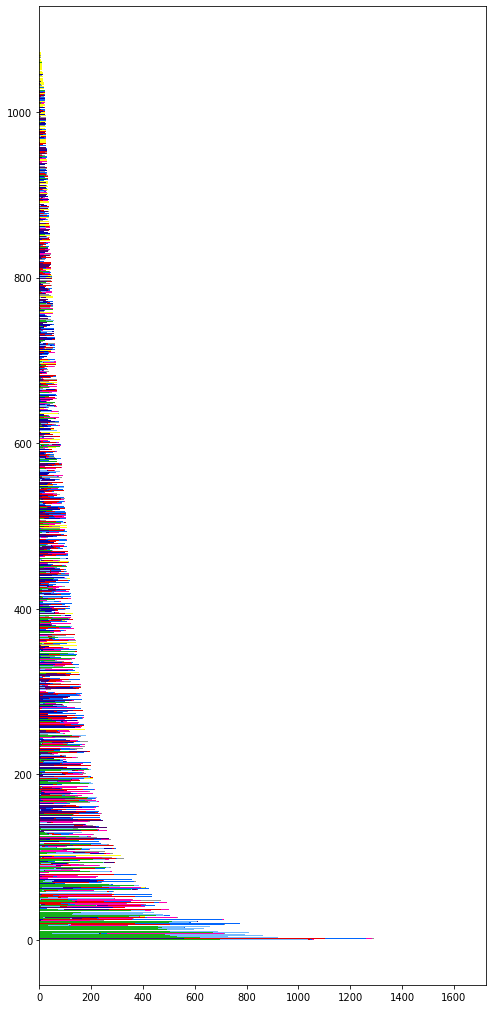

In [62]:
# barh
colors_sc = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors_sc))

plt.figure(1,figsize = [8,18])
df = counts_mn
df = df.sort_values(by = ['mn'], ascending = False)


xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

plt.show()

In [335]:
# proportion df - mn
proportion_mn_df = counts_mn.iloc[:,0:2]
proportion_mn_df = proportion_mn_df[proportion_mn_df['mn'] != 0]
proportion_mn_df['DLM'] = counts_mn.DLM / proportion_mn_df.mn
proportion_mn_df['DVM'] = counts_mn.DVM / proportion_mn_df.mn
proportion_mn_df['basalar'] = counts_mn.basalar / proportion_mn_df.mn
proportion_mn_df['firstAx'] = counts_mn.firstAx / proportion_mn_df.mn
proportion_mn_df['thirdAx'] = counts_mn.thirdAx / proportion_mn_df.mn
proportion_mn_df['hg'] = counts_mn.hg / proportion_mn_df.mn
proportion_mn_df['PS'] = counts_mn.PS / proportion_mn_df.mn
proportion_mn_df['tp_tt'] = counts_mn.tp_tt / proportion_mn_df.mn
proportion_mn_df['unknown'] = counts_mn.unknown / proportion_mn_df.mn


proportion_mn_df.head()

,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
0,648518346494696355,243,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576
1,648518346517344554,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,648518346489656701,1274,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0
3,648518346499338078,69,0.0,0.347826,0.0,0.521739,0.043478,0.0,0.086957,0.0,0.0
4,648518346487473834,48,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625


In [ ]:
# break up by hemilineages of interest

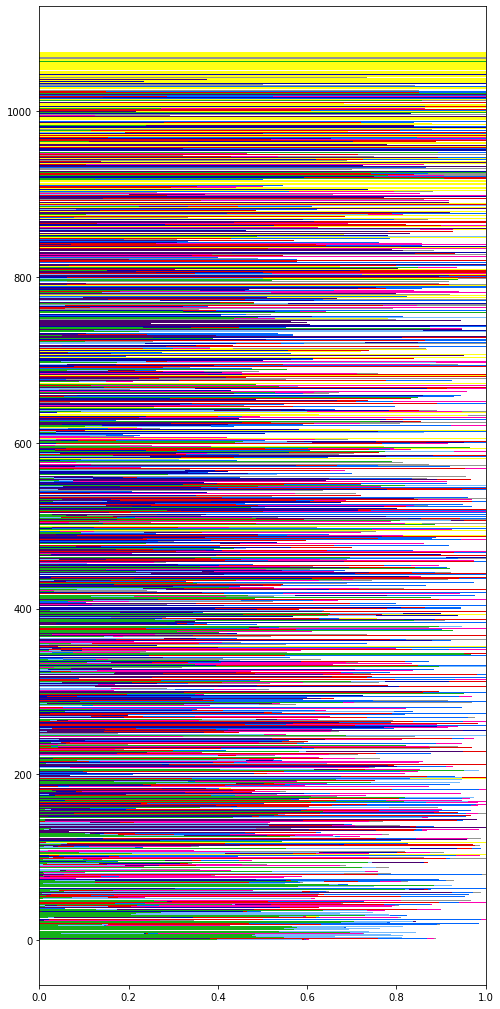

In [92]:
# barh
colors_sc = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors_sc))

plt.figure(1,figsize = [8,18])
df = proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)


xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

plt.show()

In [93]:
# break up by hemilineage designation.......
pmn19B_df = local_df[local_df.notes.isin(['19B t1', '19Ba t2', '19Ba?', '19Bb t2', '19Bb t3'])]
pmn17A_df = local_df[local_df.notes.isin(['17A t2','17A t3'])]
pmn12A_df = local_df[local_df.notes.isin(['12A t2'])]
pmn6B_df = local_df[local_df.notes.isin(['6B t2', '6B t3'])]

pmn19B_proportion_mn_df = proportion_mn_df[proportion_mn_df.SegID.isin(pmn19B_df.SegID.to_list())]
pmn17A_proportion_mn_df = proportion_mn_df[proportion_mn_df.SegID.isin(pmn17A_df.SegID.to_list())]
pmn12A_proportion_mn_df = proportion_mn_df[proportion_mn_df.SegID.isin(pmn12A_df.SegID.to_list())]
pmn6B_proportion_mn_df = proportion_mn_df[proportion_mn_df.SegID.isin(pmn6B_df.SegID.to_list())]

remainder_proportion_mn_df = proportion_mn_df[~proportion_mn_df.SegID.isin(pmn19B_df.SegID.to_list() + pmn17A_df.SegID.to_list() + pmn12A_df.SegID.to_list() + pmn6B_df.SegID.to_list())]

print(len(proportion_mn_df))
print(len(remainder_proportion_mn_df) + len(pmn19B_proportion_mn_df) + len(pmn17A_proportion_mn_df) + len(pmn12A_proportion_mn_df) + len(pmn6B_proportion_mn_df))



1263
1263


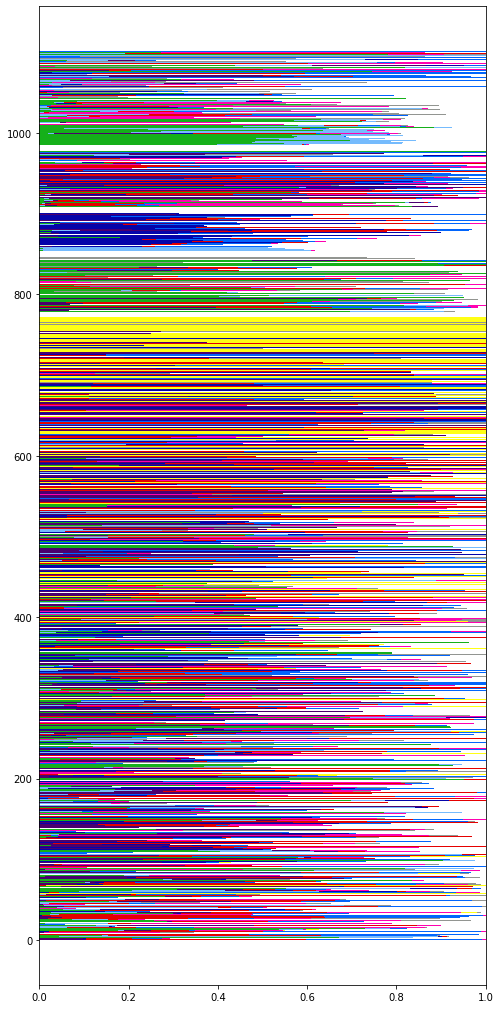

In [94]:
# barh
colors_sc = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors_sc))

plt.figure(1,figsize = [8,18])

df = remainder_proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)
xn1 = [i for i, _ in enumerate(df['mn'])]
xn1 = np.array(xn1)*0.85
plt.barh(xn1, df['DLM'])
plt.barh(xn1, df['DVM'], left = df['DLM'])
plt.barh(xn1, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn1, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn1, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn1, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn1, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn1, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn1, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

df = pmn6B_proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)
xn2 = [i for i, _ in enumerate(df['mn'])]
xn2 = np.array(xn2)*0.85
xn2 = xn2 +max(xn1)+8
plt.barh(xn2, df['DLM'])
plt.barh(xn2, df['DVM'], left = df['DLM'])
plt.barh(xn2, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn2, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn2, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn2, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn2, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn2, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn2, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

df = pmn12A_proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)
xn3 = [i for i, _ in enumerate(df['mn'])]
xn3 = np.array(xn3)*0.85
xn3 = xn3 +max(xn2)+8
plt.barh(xn3, df['DLM'])
plt.barh(xn3, df['DVM'], left = df['DLM'])
plt.barh(xn3, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn3, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn3, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn3, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn3, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn3, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn3, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

df = pmn17A_proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)
xn4 = [i for i, _ in enumerate(df['mn'])]
xn4 = np.array(xn4)*0.85
xn4 = xn4 +max(xn3)+8
plt.barh(xn4, df['DLM'])
plt.barh(xn4, df['DVM'], left = df['DLM'])
plt.barh(xn4, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn4, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

df = pmn19B_proportion_mn_df
df = df.sort_values(by = ['mn'], ascending = False)
xn5 = [i for i, _ in enumerate(df['mn'])]
xn5 = np.array(xn5)*0.85
xn5 = xn5 +max(xn4)+8
plt.barh(xn5, df['DLM'])
plt.barh(xn5, df['DVM'], left = df['DLM'])
plt.barh(xn5, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn5, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn5, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn5, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn5, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn5, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn5, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])



plt.show()

<BarContainer object of 304 artists>

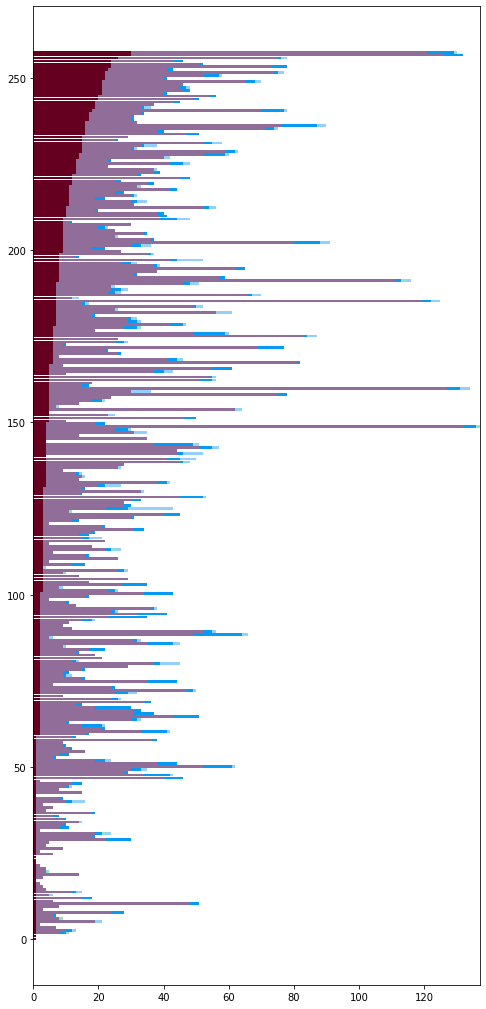

In [115]:
# barh
colors = ["#650021", "#916e99","#069af3","#90e4c1","#95d0fc","#ad8150","#929591", "#650021"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,18])
df = counts_syn

xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['mn'])
plt.barh(xn, df['local'], left = df['mn'])
plt.barh(xn, df['ascending'], left = df['local'] + df['mn'])
plt.barh(xn, df['sensory'], left = df.ascending + df.mn + df['local'])
plt.barh(xn, df['descending'], left = df.ascending + df.sensory + df.mn + df['local'])
# plt.barh(xn, df['fragment'], left = df.descending + df.ascending + df.sensory + df.mn + df['local'])
# plt.barh(xn, df['other'], left = df.fragment + df.descending + df.ascending + df.sensory + df.mn + df['local'])


In [198]:
proportion_df

,SegID,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref
0,648518346494696355,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM
1,648518346517344554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt
2,648518346489656701,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx
3,648518346499338078,0.0,0.347826,0.0,0.057971,0.043478,0.0,0.086957,0.0,0.0,DVM
4,648518346487473834,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM
...,...,...,...,...,...,...,...,...,...,...,...
1258,648518346490370826,0.0,0.0,0.0,0.16,0.0,0.0,0.0,0.0,0.0,firstAx
1259,648518346520525622,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,basalar
1260,648518346494443797,0.0,0.0,0.771429,0.0,0.0,0.0,0.0,0.0,0.0,basalar
1261,648518346472332747,0.24,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,basalar


In [273]:
DLM_list = [648518346515087943, 648518346486563887, 648518346476906768, 648518346486629017, 648518346472269618]
DVM_list = [648518346491784815, 648518346511825599, 648518346483122508, 648518346499049025, 648518346509427075, 648518346512153646, 648518346488827114]
basalar_list = [648518346499823171, 648518346481269135, 648518346493634040]
firstAx_list = [648518346518702815, 648518346499256923]
thirdAx_list = [648518346494407701, 648518346509604297, 648518346491616529,648518346482131604]
hg_list = [648518346487480490, 648518346498479344, 648518346481779133, 648518346492048172]
PS_list = [648518346492244419, 648518346497125761]
tp_tt_list = [648518346494688675, 648518346481319311, 648518346494660523, 648518346489942455]
unknown_list = [648518346489660723, 648518346472953700, 648518346472328139]

# temp_df = ut.build_synapse_df(MN_df.SegID.to_list(),"pre",3,client) 
temp_counts = pd.DataFrame(temp_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

if temp_counts.shape[0] != len(MN_df.SegID.to_list()):
    print('Warning: The following segIDs are not up to date')
    print(list(set(MN_df.SegID.to_list()) - set(temp_counts['SegID'])))

[648518346494371560, 648518346517375018, 648518346483068748, 648518346490805933, 648518346464980597, 648518346494026231, 648518346518682079]


In [191]:
temp_counts

,SegID,counts
0,648518346492244419,12883
1,648518346493634040,10605
2,648518346472269618,9465
3,648518346518702815,9356
4,648518346482131604,9092
5,648518346481779133,8848
6,648518346497125761,8743
7,648518346499256923,8460
8,648518346491616529,8419
9,648518346486563887,7424


In [136]:
precounts.iloc[:,0:2]

,SegID,counts
303,648518346476812560,74
152,648518346515027783,1500
248,648518346486491105,554
69,648518346495420578,3880
125,648518346531192602,2047
...,...,...
156,648518346518572767,1445
202,648518346489369708,918
72,648518346497841818,3739
23,648518346489570655,5900


In [331]:
# horizontal bar, one for each pmn
counts_syn =precounts.iloc[:,0:3]
this_syn_df = syn_df

counts_syn['DLM'] = ''
counts_syn['DVM'] = ''
counts_syn['basalar'] = ''
counts_syn['firstAx'] = ''
counts_syn['thirdAx'] = ''
counts_syn['hg'] = ''
counts_syn['PS'] = ''
counts_syn['tp_tt'] = ''
counts_syn['unknown'] = ''

i = 0
while i < len(counts_syn):
    pmn_i = counts_syn.SegID.iloc[i]
    syn_i = this_syn_df[this_syn_df.pre_pt_root_id.isin([pmn_i])]

    DLM_syn = syn_i[syn_i['post_pt_root_id'].isin(DLM_list)]
    DVM_syn = syn_i[syn_i['post_pt_root_id'].isin(DVM_list)]
    basalar_syn = syn_i[syn_i['post_pt_root_id'].isin(basalar_list)]
    firstAx_syn = syn_i[syn_i['post_pt_root_id'].isin(firstAx_list)]
    thirdAx_syn = syn_i[syn_i['post_pt_root_id'].isin(thirdAx_list)]
    hg_syn = syn_i[syn_i['post_pt_root_id'].isin(hg_list)]
    PS_syn = syn_i[syn_i['post_pt_root_id'].isin(PS_list)]
    tp_tt_syn = syn_i[syn_i['post_pt_root_id'].isin(tp_tt_list)]
    unknown_syn = syn_i[syn_i['post_pt_root_id'].isin(unknown_list)]

    counts_syn['DLM'].iloc[i] = len(DLM_syn)
    counts_syn['DVM'].iloc[i] = len(DVM_syn)
    counts_syn['basalar'].iloc[i] = len(basalar_syn)
    counts_syn['firstAx'].iloc[i] = len(firstAx_syn)
    counts_syn['thirdAx'].iloc[i] = len(thirdAx_syn)
    counts_syn['hg'].iloc[i] = len(hg_syn)
    counts_syn['PS'].iloc[i] = len(PS_syn)
    counts_syn['tp_tt'].iloc[i] = len(tp_tt_syn)
    counts_syn['unknown'].iloc[i] = len(unknown_syn)

    i = i+1

counts_syn


/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,SegID,counts,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
0,648518346495720080,344,0,0,0,0,0,0,0,0,0
1,648518346526171095,314,7,72,0,0,27,0,302,0,0
2,648518346494064891,305,11,8,0,0,54,0,139,0,0
3,648518346483999261,301,0,0,0,0,0,0,0,0,0
4,648518346504777587,296,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2793,648518346501007216,3,0,0,0,0,0,0,0,0,0
2794,648518346485741288,3,0,0,0,0,0,0,0,0,0
2795,648518346475017088,3,0,0,0,0,0,0,0,0,0
2796,648518346488912089,3,0,0,0,0,0,0,0,0,0


In [144]:
min(counts_syn.mn)

0

<BarContainer object of 304 artists>

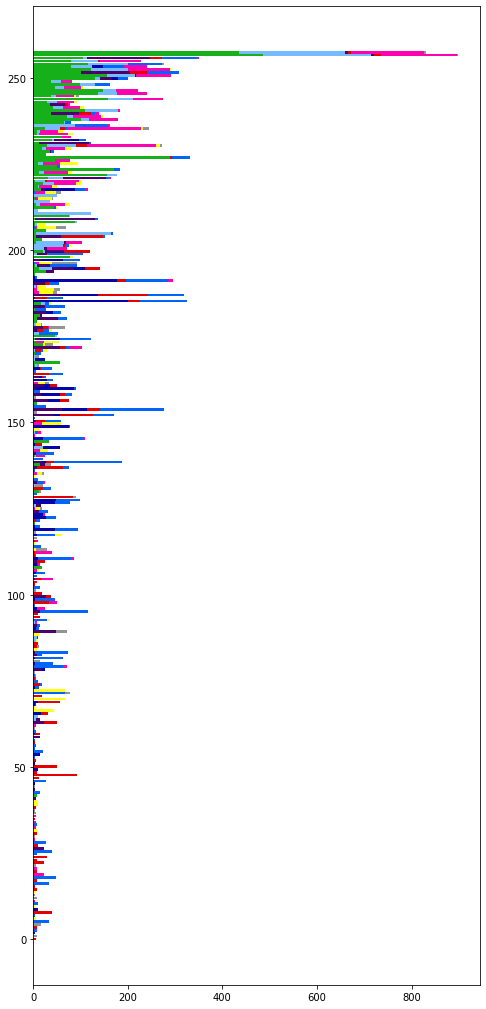

In [126]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors))


plt.figure(1,figsize = [8,18])
df = counts_syn

xn = [i for i, _ in enumerate(df['SegID'])]
xn = np.array(xn)*0.85

plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

In [333]:
counts_syn

,SegID,counts,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
0,648518346495720080,344,0,0,0,0,0,0,0,0,0
1,648518346526171095,314,7,72,0,0,27,0,302,0,0
2,648518346494064891,305,11,8,0,0,54,0,139,0,0
3,648518346483999261,301,0,0,0,0,0,0,0,0,0
4,648518346504777587,296,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2793,648518346501007216,3,0,0,0,0,0,0,0,0,0
2794,648518346485741288,3,0,0,0,0,0,0,0,0,0
2795,648518346475017088,3,0,0,0,0,0,0,0,0,0
2796,648518346488912089,3,0,0,0,0,0,0,0,0,0


In [332]:
# assign a frational value to pseudo rank order
# remove if 0 to mn
counts_syn= counts_syn[counts_syn['mn'] != 0]

proportion_df = counts_syn.iloc[:,0:1]

proportion_df['DLM'] = counts_syn.DLM / counts_syn.mn
proportion_df['DVM'] = counts_syn.DVM / counts_syn.mn

proportion_df['basalar'] = counts_syn.basalar / counts_syn.mn
proportion_df['firstAx'] = counts_syn.firstAx / counts_syn.mn
proportion_df['thirdAx'] = counts_syn.thirdAx / counts_syn.mn
proportion_df['hg'] = counts_syn.hg / counts_syn.mn

proportion_df['PS'] = counts_syn.PS / counts_syn.mn
proportion_df['tp_tt'] = counts_syn.tp_tt / counts_syn.mn
proportion_df['unknown'] = counts_syn.unknown / counts_syn.mn


proportion_df = proportion_df.reset_index(drop = True)
proportion_df

KeyError: 'mn'

In [341]:
temp_df

,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
0,243.0,0.00,0.847737,0.000000,0.000000,0.000000,0.00000,0.000000,0.09465,0.020576
1,19.0,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
2,1274.0,0.00,0.000000,0.105181,0.000000,0.492936,0.39325,0.008634,0.00000,0.000000
3,69.0,0.00,0.347826,0.000000,0.521739,0.043478,0.00000,0.086957,0.00000,0.000000
4,48.0,0.00,0.500000,0.000000,0.000000,0.000000,0.00000,0.000000,0.43750,0.062500
...,...,...,...,...,...,...,...,...,...,...
1259,25.0,0.00,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1260,27.0,0.00,0.000000,0.777778,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1261,35.0,0.00,0.000000,0.771429,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
1262,25.0,0.24,0.000000,0.600000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000


In [345]:
# assign motor pool
proportion_mn_df= proportion_mn_df[proportion_mn_df['mn'] != 0].reset_index(drop =True)

proportion_mn_df['pref'] = ''
temp_df = proportion_mn_df.iloc[:,2:-1].astype(float)

i = 0
while i < len(proportion_mn_df):
    proportion_mn_df['pref'].iloc[i] = temp_df.loc[i].idxmax()
    i = i +1



/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [346]:
proportion_mn_df

,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref
0,648518346494696355,243,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM
1,648518346517344554,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt
2,648518346489656701,1274,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx
3,648518346499338078,69,0.0,0.347826,0.0,0.521739,0.043478,0.0,0.086957,0.0,0.0,firstAx
4,648518346487473834,48,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM
...,...,...,...,...,...,...,...,...,...,...,...,...
1258,648518346490370826,25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,firstAx
1259,648518346520525622,27,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,basalar
1260,648518346494443797,35,0.0,0.0,0.771429,0.0,0.0,0.0,0.0,0.0,0.0,basalar
1261,648518346472332747,25,0.24,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,basalar


1263

In [195]:
DLM_pref_ids = proportion_df[proportion_df.pref.isin(['DLM'])]
DVM_pref_ids = proportion_df[proportion_df.pref.isin(['DVM'])]
bas_pref_ids = proportion_df[proportion_df.pref.isin(['basalar'])]
i_pref_ids = proportion_df[proportion_df.pref.isin(['firstAx'])]
iii_pref_ids = proportion_df[proportion_df.pref.isin(['thirdAx'])]
hg_pref_ids = proportion_df[proportion_df.pref.isin(['hg'])]
PS_pref_ids = proportion_df[proportion_df.pref.isin(['PS'])]
tptt_pref_ids = proportion_df[proportion_df.pref.isin(['tp_tt'])]
uk_pref_ids = proportion_df[proportion_df.pref.isin(['unknown'])]

rank_ordered_proportion = pd.concat([DLM_pref_ids, DVM_pref_ids, bas_pref_ids, i_pref_ids, iii_pref_ids, hg_pref_ids, PS_pref_ids, tptt_pref_ids, uk_pref_ids])

In [151]:
df1 = counts_syn[counts_syn.SegID.isin(DLM_pref_ids.SegID.to_list())]
df2 = counts_syn[counts_syn.SegID.isin(DVM_pref_ids.SegID.to_list())]
df3 = counts_syn[counts_syn.SegID.isin(bas_pref_ids.SegID.to_list())]
df4 = counts_syn[counts_syn.SegID.isin(i_pref_ids.SegID.to_list())]
df5 = counts_syn[counts_syn.SegID.isin(iii_pref_ids.SegID.to_list())]
df6 = counts_syn[counts_syn.SegID.isin(hg_pref_ids.SegID.to_list())]
df7 = counts_syn[counts_syn.SegID.isin(PS_pref_ids.SegID.to_list())]
df8 = counts_syn[counts_syn.SegID.isin(tptt_pref_ids.SegID.to_list())]
df9 = counts_syn[counts_syn.SegID.isin(uk_pref_ids.SegID.to_list())]

rank_ordered = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

<BarContainer object of 1263 artists>

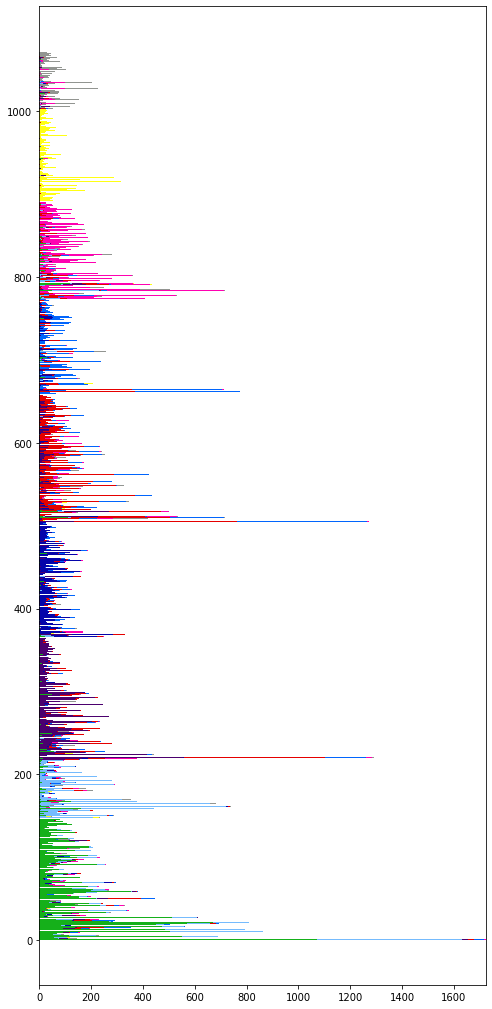

In [152]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors))


plt.figure(1,figsize = [8,18])
df = rank_ordered

xn = [i for i, _ in enumerate(df['SegID'])]
xn = np.array(xn)*0.85

plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

<BarContainer object of 1263 artists>

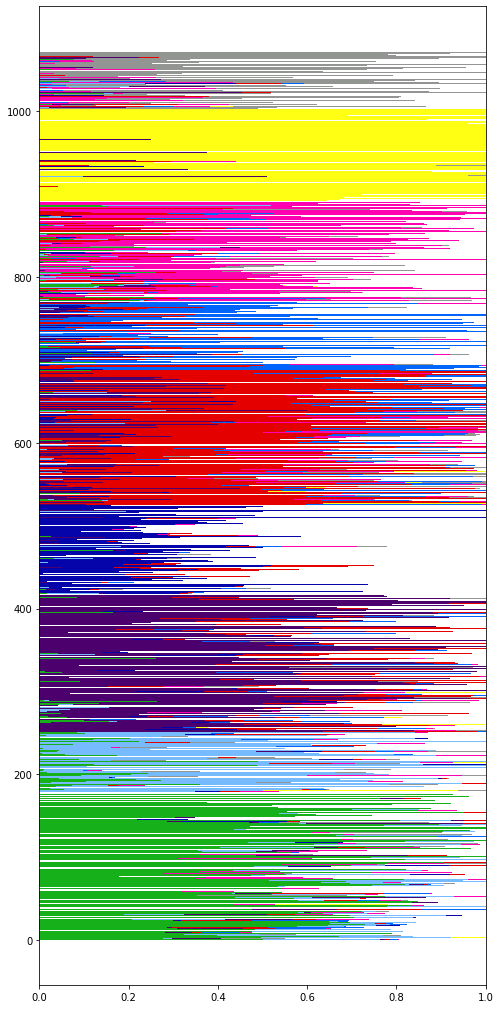

In [196]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors))


plt.figure(1,figsize = [8,18])
df = rank_ordered_proportion

xn = [i for i, _ in enumerate(df['SegID'])]
xn = np.array(xn)*0.85

plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

In [199]:
# order by NT type...

# ACh
subset_df = proportion_df[proportion_df.SegID.isin(ACh_df.SegID.to_list())]

DLM_pref_ids = subset_df[subset_df.pref.isin(['DLM'])]
DVM_pref_ids = subset_df[subset_df.pref.isin(['DVM'])]
bas_pref_ids = subset_df[subset_df.pref.isin(['basalar'])]
i_pref_ids = subset_df[subset_df.pref.isin(['firstAx'])]
iii_pref_ids = subset_df[subset_df.pref.isin(['thirdAx'])]
hg_pref_ids = subset_df[subset_df.pref.isin(['hg'])]
PS_pref_ids = subset_df[subset_df.pref.isin(['PS'])]
tptt_pref_ids = subset_df[subset_df.pref.isin(['tp_tt'])]
uk_pref_ids = subset_df[subset_df.pref.isin(['unknown'])]

ACh_ordered = pd.concat([DLM_pref_ids,DVM_pref_ids,bas_pref_ids,i_pref_ids,iii_pref_ids,hg_pref_ids,PS_pref_ids,tptt_pref_ids,uk_pref_ids])


<BarContainer object of 457 artists>

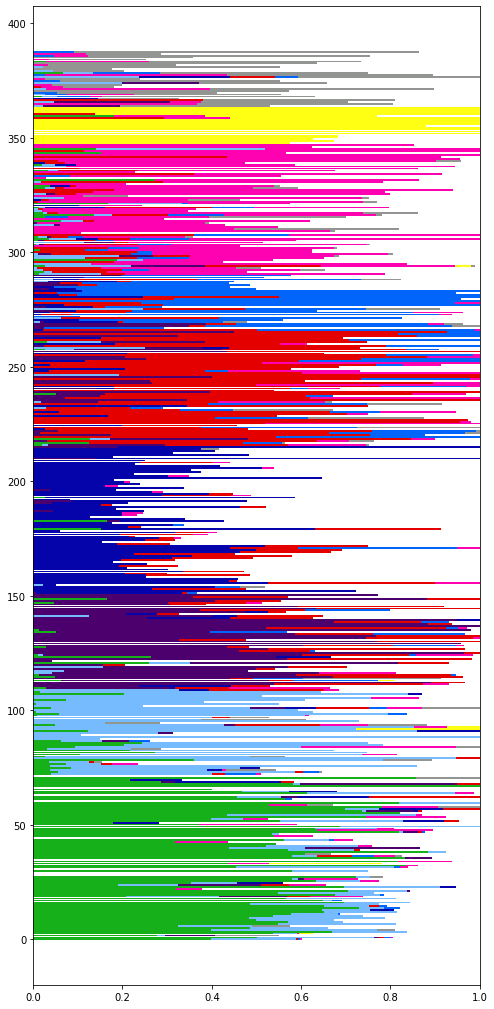

In [200]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors))


plt.figure(1,figsize = [8,18])
df = ACh_ordered

xn = [i for i, _ in enumerate(df['SegID'])]
xn = np.array(xn)*0.85

plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

In [202]:
# order by NT type...

# GABA
subset_df = proportion_df[proportion_df.SegID.isin(GABA_df.SegID.to_list())]

DLM_pref_ids = subset_df[subset_df.pref.isin(['DLM'])]
DVM_pref_ids = subset_df[subset_df.pref.isin(['DVM'])]
bas_pref_ids = subset_df[subset_df.pref.isin(['basalar'])]
i_pref_ids = subset_df[subset_df.pref.isin(['firstAx'])]
iii_pref_ids = subset_df[subset_df.pref.isin(['thirdAx'])]
hg_pref_ids = subset_df[subset_df.pref.isin(['hg'])]
PS_pref_ids = subset_df[subset_df.pref.isin(['PS'])]
tptt_pref_ids = subset_df[subset_df.pref.isin(['tp_tt'])]
uk_pref_ids = subset_df[subset_df.pref.isin(['unknown'])]

GABA_ordered = pd.concat([DLM_pref_ids,DVM_pref_ids,bas_pref_ids,i_pref_ids,iii_pref_ids,hg_pref_ids,PS_pref_ids,tptt_pref_ids,uk_pref_ids])


# Glu
subset_df = proportion_df[proportion_df.SegID.isin(Glu_df.SegID.to_list())]

DLM_pref_ids = subset_df[subset_df.pref.isin(['DLM'])]
DVM_pref_ids = subset_df[subset_df.pref.isin(['DVM'])]
bas_pref_ids = subset_df[subset_df.pref.isin(['basalar'])]
i_pref_ids = subset_df[subset_df.pref.isin(['firstAx'])]
iii_pref_ids = subset_df[subset_df.pref.isin(['thirdAx'])]
hg_pref_ids = subset_df[subset_df.pref.isin(['hg'])]
PS_pref_ids = subset_df[subset_df.pref.isin(['PS'])]
tptt_pref_ids = subset_df[subset_df.pref.isin(['tp_tt'])]
uk_pref_ids = subset_df[subset_df.pref.isin(['unknown'])]

Glu_ordered = pd.concat([DLM_pref_ids,DVM_pref_ids,bas_pref_ids,i_pref_ids,iii_pref_ids,hg_pref_ids,PS_pref_ids,tptt_pref_ids,uk_pref_ids])


# Other
subset_df = proportion_df[proportion_df.SegID.isin(OtherNT_df.SegID.to_list())]

DLM_pref_ids = subset_df[subset_df.pref.isin(['DLM'])]
DVM_pref_ids = subset_df[subset_df.pref.isin(['DVM'])]
bas_pref_ids = subset_df[subset_df.pref.isin(['basalar'])]
i_pref_ids = subset_df[subset_df.pref.isin(['firstAx'])]
iii_pref_ids = subset_df[subset_df.pref.isin(['thirdAx'])]
hg_pref_ids = subset_df[subset_df.pref.isin(['hg'])]
PS_pref_ids = subset_df[subset_df.pref.isin(['PS'])]
tptt_pref_ids = subset_df[subset_df.pref.isin(['tp_tt'])]
uk_pref_ids = subset_df[subset_df.pref.isin(['unknown'])]

OtherNT_ordered = pd.concat([DLM_pref_ids,DVM_pref_ids,bas_pref_ids,i_pref_ids,iii_pref_ids,hg_pref_ids,PS_pref_ids,tptt_pref_ids,uk_pref_ids])

<BarContainer object of 455 artists>

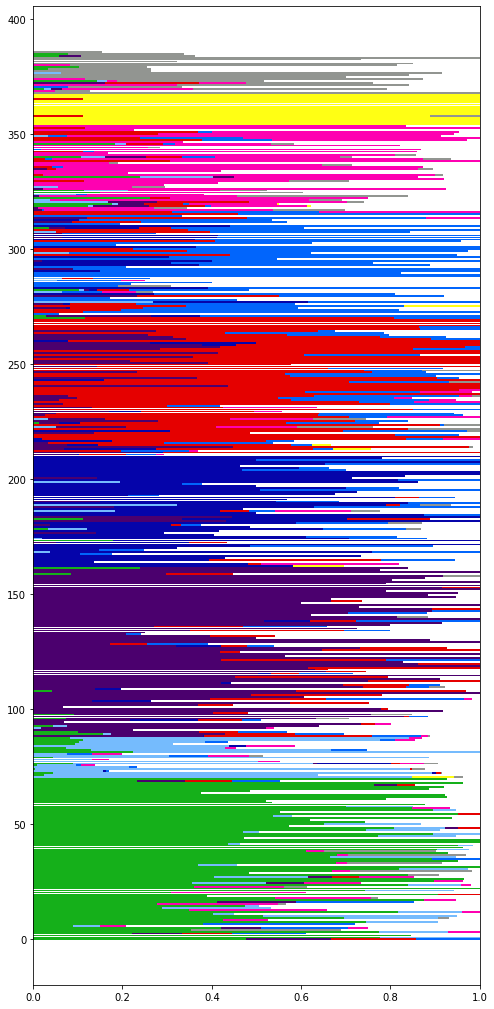

In [163]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
cmap = sns.set_palette(sns.color_palette(colors))


plt.figure(1,figsize = [8,18])
df = GABA_ordered

xn = [i for i, _ in enumerate(df['SegID'])]
xn = np.array(xn)*0.85

plt.barh(xn, df['DLM'])
plt.barh(xn, df['DVM'], left = df['DLM'])
plt.barh(xn, df['basalar'], left = df['DVM'] + df['DLM'])
plt.barh(xn, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])

In [165]:
print(len(ACh_ordered))
print(len(GABA_ordered))

457
455


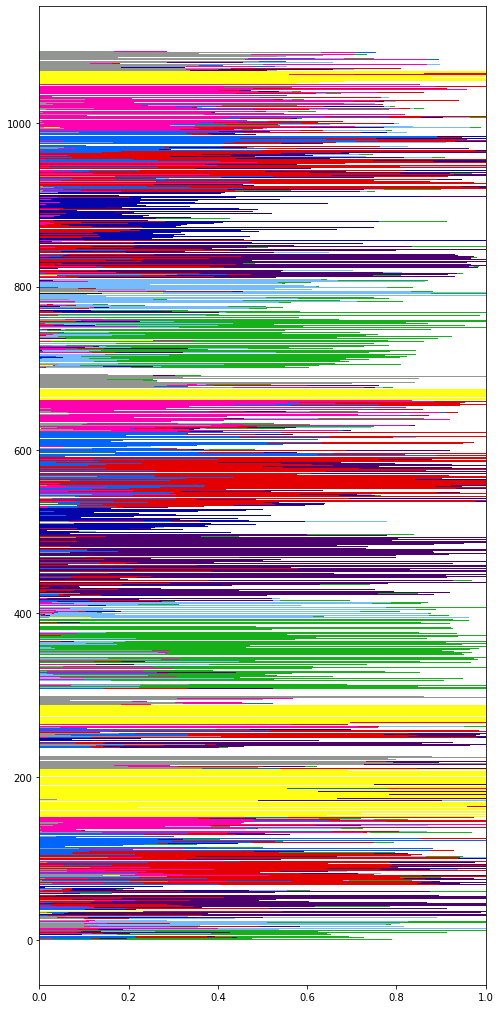

In [209]:
# colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
colors = ["#929591", "#ffff14","#fe01b1","#0165fc","#e50000","#0504aa","#4b006e", "#75bbfd", "#15b01a"] # reversed
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,18])

df = OtherNT_ordered
# df = df.sort_values(by = ['mn'], ascending = False)
xn1 = [i for i, _ in enumerate(df['SegID'])]
xn1 = np.array(xn1)*0.85
plt.barh(xn1, df['unknown'])
plt.barh(xn1, df['tp_tt'], left = df['unknown'])
plt.barh(xn1, df['PS'], left = df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['hg'], left = df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['thirdAx'], left = df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['firstAx'], left = df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['basalar'], left = df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['DVM'], left = df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn1, df['DLM'], left = df['DVM'] + df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])

df = Glu_ordered
# df = df.sort_values(by = ['mn'], ascending = False)
xn2 = [i for i, _ in enumerate(df['SegID'])]
xn2 = np.array(xn2)*0.85
xn2 = xn2 +max(xn1)+8
plt.barh(xn2, df['unknown'])
plt.barh(xn2, df['tp_tt'], left = df['unknown'])
plt.barh(xn2, df['PS'], left = df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['hg'], left = df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['thirdAx'], left = df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['firstAx'], left = df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['basalar'], left = df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['DVM'], left = df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn2, df['DLM'], left = df['DVM'] + df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])

df = GABA_ordered
# df = df.sort_values(by = ['mn'], ascending = False)
xn3 = [i for i, _ in enumerate(df['SegID'])]
xn3 = np.array(xn3)*0.85
xn3 = xn3 +max(xn2)+8
plt.barh(xn3, df['unknown'])
plt.barh(xn3, df['tp_tt'], left = df['unknown'])
plt.barh(xn3, df['PS'], left = df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['hg'], left = df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['thirdAx'], left = df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['firstAx'], left = df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['basalar'], left = df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['DVM'], left = df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn3, df['DLM'], left = df['DVM'] + df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])

df = ACh_ordered
# df = df.sort_values(by = ['mn'], ascending = False)
xn4 = [i for i, _ in enumerate(df['SegID'])]
xn4 = np.array(xn4)*0.85
xn4 = xn4 +max(xn3)+8
# plt.barh(xn4, df['DLM'])
# plt.barh(xn4, df['DVM'], left = df['DLM'])
# plt.barh(xn4, df['basalar'], left = df['DVM'] + df['DLM'])
# plt.barh(xn4, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
# plt.barh(xn4, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
# plt.barh(xn4, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
# plt.barh(xn4, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
# plt.barh(xn4, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
# plt.barh(xn4, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
plt.barh(xn4, df['unknown'])
plt.barh(xn4, df['tp_tt'], left = df['unknown'])
plt.barh(xn4, df['PS'], left = df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['hg'], left = df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['thirdAx'], left = df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['firstAx'], left = df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['basalar'], left = df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['DVM'], left = df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])
plt.barh(xn4, df['DLM'], left = df['DVM'] + df['basalar'] + df['firstAx'] + df['thirdAx'] + df['hg'] + df['PS'] + df['tp_tt'] + df['unknown'])

plt.show()

In [213]:
counts_syn = counts_syn.assign(Rside=lambda x: (x['mn'] - (x['DLM']+x['DVM']+x['basalar']+x['firstAx']+x['thirdAx']+x['hg']+x['PS']+x['tp_tt']+x['unknown'])))
counts_syn



,SegID,counts,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,Rside
0,648518346494696355,14659,243,0,206,0,0,0,0,0,23,5,9
1,648518346517344554,11163,19,0,0,0,0,0,0,0,19,0,0
2,648518346489656701,8476,1274,0,0,134,0,628,501,11,0,0,0
3,648518346499338078,8190,69,0,24,0,4,3,0,6,0,0,32
4,648518346487473834,7795,48,0,24,0,0,0,0,0,21,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,648518346490370826,43,25,0,0,0,4,0,0,0,0,0,21
1260,648518346520525622,43,27,0,0,21,0,0,0,0,0,0,6
1261,648518346494443797,42,35,0,0,27,0,0,0,0,0,0,8
1262,648518346472332747,39,25,6,0,15,0,0,0,0,0,0,4


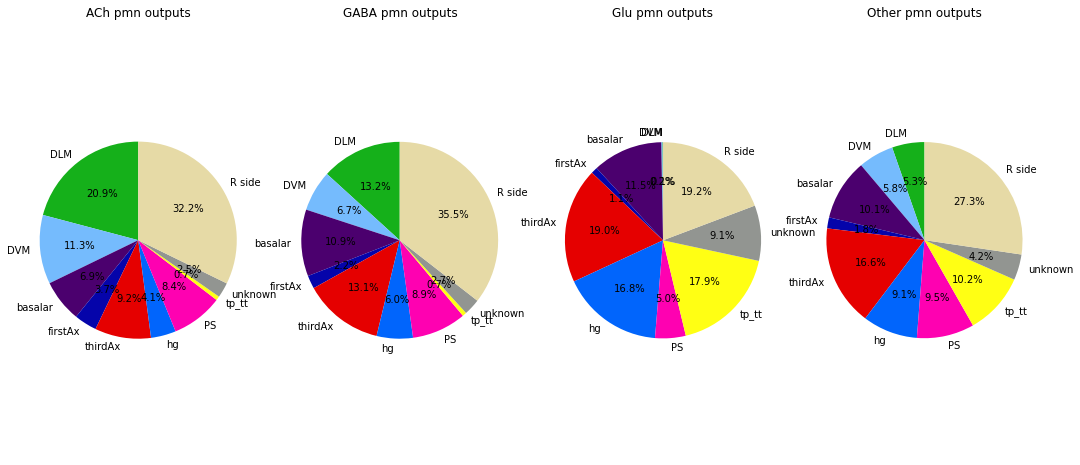

In [228]:
# pie plots
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591", "#e6daa6"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [18,8])


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'DLM', 'DVM', 'basalar', 'firstAx', 'thirdAx', 'hg', 'PS', 'tp_tt', 'unknown', 'R side'

plt.subplot(1, 4, 1)
df = counts_syn[counts_syn.SegID.isin(ACh_ordered.SegID.to_list())]
sizes = [sum(df.DLM), sum(df.DVM), sum(df.basalar), sum(df.firstAx), sum(df.thirdAx), sum(df.hg), sum(df.PS), sum(df.tp_tt), sum(df.unknown), sum(df.Rside)]
plt.pie(sizes, autopct='%1.1f%%', labels = labels,
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('ACh pmn outputs')

plt.subplot(1, 4, 2)
df = counts_syn[counts_syn.SegID.isin(GABA_ordered.SegID.to_list())]
sizes = [sum(df.DLM), sum(df.DVM), sum(df.basalar), sum(df.firstAx), sum(df.thirdAx), sum(df.hg), sum(df.PS), sum(df.tp_tt), sum(df.unknown), sum(df.Rside)]
plt.pie(sizes, autopct='%1.1f%%', labels = labels,
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('GABA pmn outputs')

plt.subplot(1, 4, 3)
df = counts_syn[counts_syn.SegID.isin(Glu_ordered.SegID.to_list())]
sizes = [sum(df.DLM), sum(df.DVM), sum(df.basalar), sum(df.firstAx), sum(df.thirdAx), sum(df.hg), sum(df.PS), sum(df.tp_tt), sum(df.unknown), sum(df.Rside)]
plt.pie(sizes, autopct='%1.1f%%', labels = labels,
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Glu pmn outputs')

plt.subplot(1, 4, 4)
df = counts_syn[counts_syn.SegID.isin(OtherNT_ordered.SegID.to_list())]
sizes = [sum(df.DLM), sum(df.DVM), sum(df.basalar), sum(df.firstAx), sum(df.thirdAx), sum(df.hg), sum(df.PS), sum(df.tp_tt), sum(df.unknown), sum(df.Rside)]
plt.pie(sizes, autopct='%1.1f%%', labels = labels,
        shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Other pmn outputs')

plt.savefig('pmnTargets.png', format='png', bbox_inches='tight')
plt.show()

In [216]:
ACh_ordered

,SegID,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref
26,648518346486676988,0.397385,0.191586,0.0,0.0,0.00398,0.005117,0.005117,0.0,0.0,DLM
30,648518346491506374,0.500935,0.262862,0.009822,0.0,0.011225,0.017306,0.003742,0.0,0.0,DLM
37,648518346489337029,0.276923,0.019231,0.111538,0.0,0.0,0.0,0.0,0.0,0.142308,DLM
52,648518346520531510,0.53621,0.05547,0.0,0.0,0.0,0.0,0.004622,0.030817,0.0,DLM
96,648518346498361649,0.670316,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DLM
...,...,...,...,...,...,...,...,...,...,...,...
957,648518346517372458,0.0,0.0,0.0,0.0,0.0,0.0,0.036145,0.0,0.216867,unknown
979,648518346488672497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.358491,unknown
1008,648518346496520316,0.0,0.0,0.0,0.0,0.0,0.04717,0.075472,0.0,0.632075,unknown
1053,648518346504389868,0.0,0.0,0.0,0.0,0.0,0.0,0.119048,0.0,0.166667,unknown


In [153]:
df1 = counts_syn[counts_syn.SegID.isin(DLM_pref_ids.SegID.to_list())]
df2 = counts_syn[counts_syn.SegID.isin(DVM_pref_ids.SegID.to_list())]
df3 = counts_syn[counts_syn.SegID.isin(bas_pref_ids.SegID.to_list())]
df4 = counts_syn[counts_syn.SegID.isin(i_pref_ids.SegID.to_list())]
df5 = counts_syn[counts_syn.SegID.isin(iii_pref_ids.SegID.to_list())]
df6 = counts_syn[counts_syn.SegID.isin(hg_pref_ids.SegID.to_list())]
df7 = counts_syn[counts_syn.SegID.isin(PS_pref_ids.SegID.to_list())]
df8 = counts_syn[counts_syn.SegID.isin(tptt_pref_ids.SegID.to_list())]
df9 = counts_syn[counts_syn.SegID.isin(uk_pref_ids.SegID.to_list())]

rank_ordered = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

In [166]:
len(xn)

455

In [155]:
df

,SegID,counts,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
26,648518346486676988,4864,1759,699,337,0,0,7,9,9,0,0
30,648518346491506374,4408,2138,1071,562,21,0,24,37,8,0,0
37,648518346489337029,4109,260,72,5,29,3,0,0,0,0,37
52,648518346520531510,3683,649,348,36,0,0,0,0,3,20,0
83,648518346496977836,2616,117,58,50,0,0,0,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1206,648518346478566484,124,44,0,0,0,0,0,4,0,0,34
1209,648518346487995678,121,50,0,0,0,0,0,0,0,0,46
1216,648518346475244856,118,30,0,0,0,0,0,0,0,0,30
1229,648518346501071638,102,25,0,0,0,0,0,0,0,0,22


KeyError: 'local'

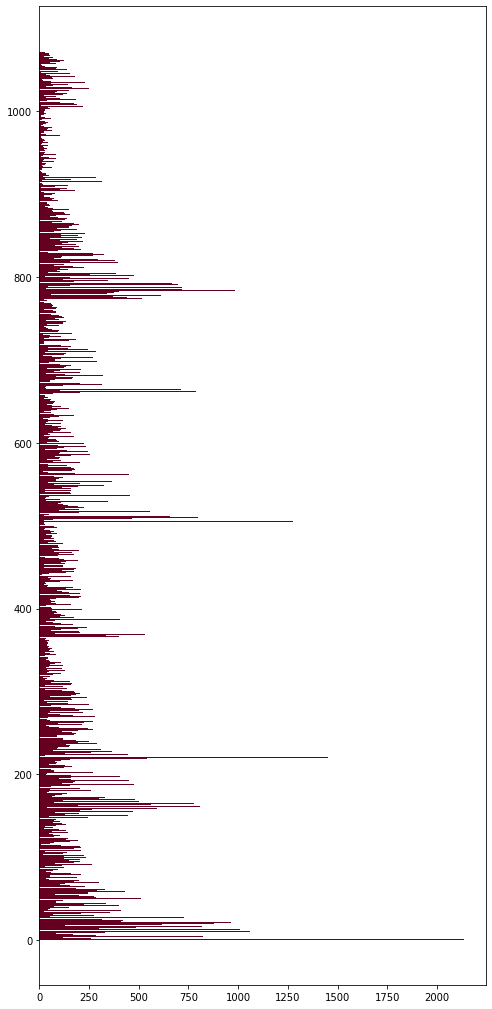

In [154]:
# barh
colors = ["#650021", "#916e99","#069af3","#90e4c1","#95d0fc","#ad8150","#929591", "#650021"]
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,18])
df = rank_ordered

xn = [i for i, _ in enumerate(df['mn'])]
xn = np.array(xn)*0.85
plt.barh(xn, df['mn'])
plt.barh(xn, df['pmn'], left = df['mn'])
# plt.barh(xn, df['local'], left = df['mn'])
# plt.barh(xn, df['ascending'], left = df['local'] + df['mn'])
# plt.barh(xn, df['sensory'], left = df.ascending + df.mn + df['local'])
# plt.barh(xn, df['descending'], left = df.ascending + df.sensory + df.mn + df['local'])
# plt.barh(xn, df['fragment'], left = df.descending + df.ascending + df.sensory + df.mn + df['local'])
# plt.barh(xn, df['other'], left = df.fragment + df.descending + df.ascending + df.sensory + df.mn + df['local'])

In [252]:
counts_syn

,SegID,counts,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
303,648518346476812560,74,1,0,0,0,0,6,0,0,0,0
152,648518346515027783,1500,1,0,0,0,0,0,0,0,0,8
248,648518346486491105,554,1,0,0,0,4,0,0,0,0,0
69,648518346495420578,3880,1,0,0,0,0,0,7,0,0,0
125,648518346531192602,2047,1,0,0,0,0,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
156,648518346518572767,1445,24,115,86,0,0,0,71,0,0,4
202,648518346489369708,918,24,80,58,0,0,3,0,86,0,0
72,648518346497841818,3739,26,105,8,134,0,26,74,3,0,0
23,648518346489570655,5900,30,486,228,6,0,15,0,161,0,3


In [254]:
rank_ordered

,SegID,counts,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown
214,648518346492176255,763,1,8,0,0,0,0,0,0,0,0
260,648518346475784418,475,3,18,0,0,0,0,0,0,0,0
283,648518346475026488,305,3,3,0,0,0,0,0,0,0,0
175,648518346481494943,1130,3,12,0,0,0,0,0,0,0,4
146,648518346507038024,1626,4,15,0,10,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
172,648518346500247356,1184,5,0,0,0,0,0,0,0,0,8
198,648518346474401218,940,5,0,0,0,0,0,0,0,0,6
297,648518346479360722,167,6,0,4,0,0,0,0,0,0,9
86,648518346472251186,3284,6,0,0,20,0,11,0,3,0,33


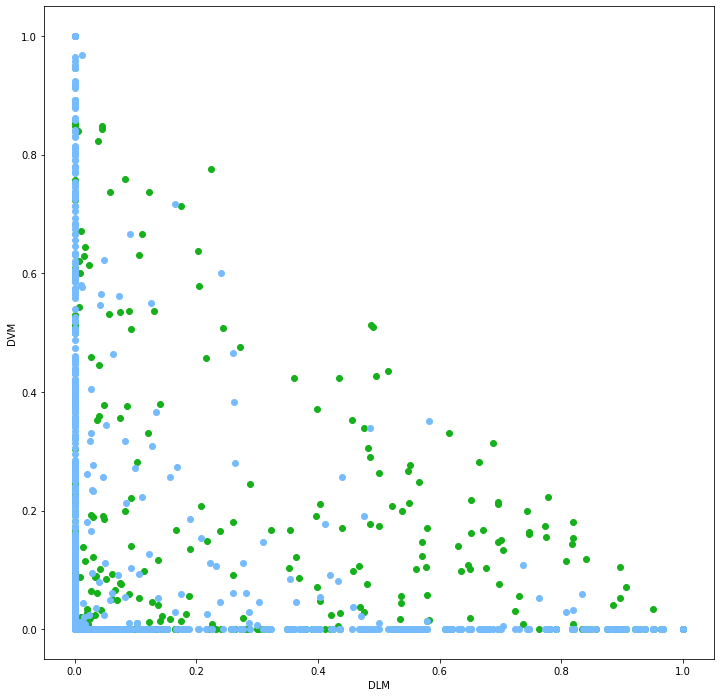

In [233]:
# x y plots comparing proportions to different sclerites

# NT_colors = ["#15b01a", "#cb416b", "#fedf08", "#d8dcd6"]
# cmap = sns.set_palette(sns.color_palette(NT_colors))

plt.figure(1,figsize = [12,12])

df = proportion_df
plt.scatter(df.DLM,df.DVM)
plt.scatter(df.DLM,df.basalar)



plt.xlabel('DLM')
plt.ylabel('DVM')
# plt.xlim(0,0.9)
# plt.ylim(0,0.9)

plt.show()


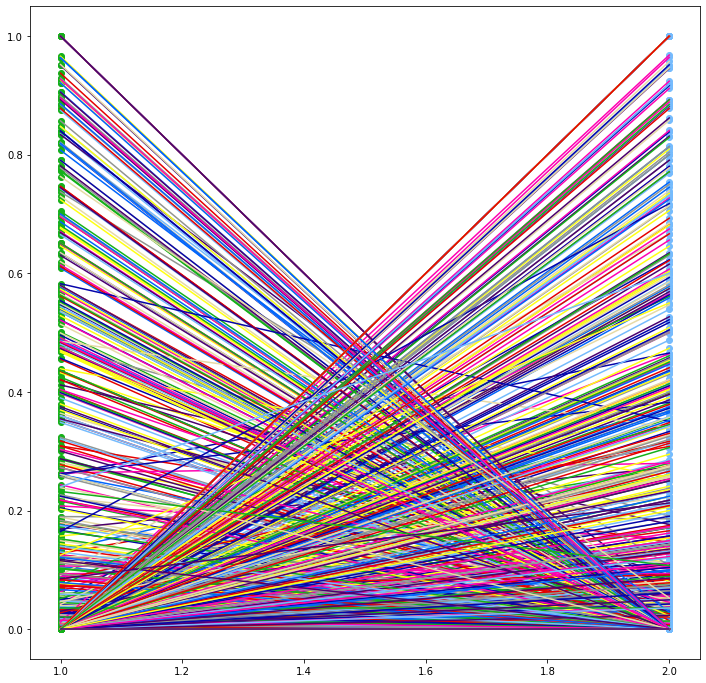

In [244]:

plt.figure(1,figsize = [12,12])

df = proportion_df
xn = np.ones(df.shape[0])
plt.scatter(xn,df.DLM)
plt.scatter(xn*2,df.basalar)
plt.plot([xn,xn*2],[df.DLM,df.basalar])


# plt.xlabel('DLM')
# plt.ylabel('DVM')
# plt.xlim(0,0.9)
# plt.ylim(0,0.9)

plt.show()

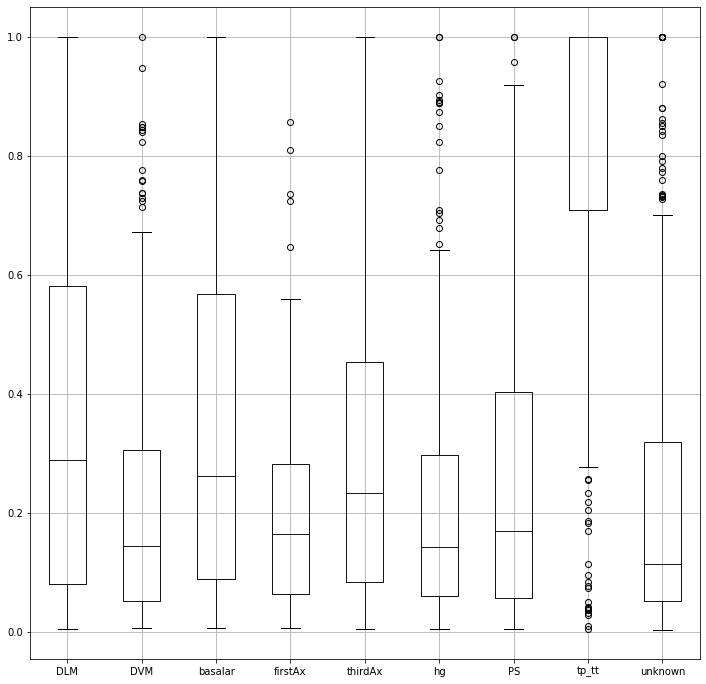

In [263]:
# df = df.iloc[:,0:-1].astype(float)
plt.figure(1,figsize = [12,12])

# boxplot = df.boxplot(column=['DLM', 'DVM'])  
df.mask(df == 0).boxplot(column=['DLM', 'DVM', 'basalar', 'firstAx', 'thirdAx', 'hg', 'PS', 'tp_tt', 'unknown'])



plt.show()


In [248]:
df.head()

,SegID,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref
0,648518346494696355,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM
1,648518346517344554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt
2,648518346489656701,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx
3,648518346499338078,0.0,0.347826,0.0,0.057971,0.043478,0.0,0.086957,0.0,0.0,DVM
4,648518346487473834,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM


In [249]:
df['DLM']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
1258     0.0
1259     0.0
1260     0.0
1261    0.24
1262     0.0
Name: DLM, Length: 1263, dtype: object

In [311]:
# who are most motor-y?
counts_syn = counts_syn.assign(pMN=lambda x: (x['mn'] / (x['counts'])))
counts_syn = counts_syn.sort_values(by = 'pMN', ascending = False)

counts_syn.head()

,SegID,counts,mn,pmn,other,local,ascending,sensory,descending,fragment,pMN
1186,648518346493100096,143,132,5,11,0,0,0,0,2,0.923077
1148,648518346499432167,175,156,13,15,1,0,0,0,4,0.891429
1176,648518346489478853,153,136,15,17,0,0,0,0,3,0.888889
576,648518346489741875,563,477,8,78,2,0,0,0,20,0.847247
1261,648518346494443797,42,35,0,7,0,0,0,0,0,0.833333


In [313]:
counts_syn.notes.value_counts()

3B     159
19B    138
6A      91
6B      84
17A     81
11B     66
7B      62
12A     56
8B      48
18B     29
21A     27
16B     23
11A     23
5B      23
0       17
2A      15
8A      13
1A       9
3A       8
12B      8
13B      8
20A      3
23B      1
1B       1
Name: notes, dtype: int64

In [312]:
counts_syn = counts_syn.merge(premotor_df, how = 'inner')
counts_syn.head()

,SegID,counts,mn,pmn,other,local,ascending,sensory,descending,fragment,pMN,class,notes,notes1
0,648518346493100096,143,132,5,11,0,0,0,0,2,0.923077,local,3B,3Ba t1
1,648518346499432167,175,156,13,15,1,0,0,0,4,0.891429,local,3B,3Ba t1
2,648518346489478853,153,136,15,17,0,0,0,0,3,0.888889,local,3B,3Ba t1
3,648518346489741875,563,477,8,78,2,0,0,0,20,0.847247,local,12A,12A t2
4,648518346494443797,42,35,0,7,0,0,0,0,0,0.833333,local,17A,17A t2


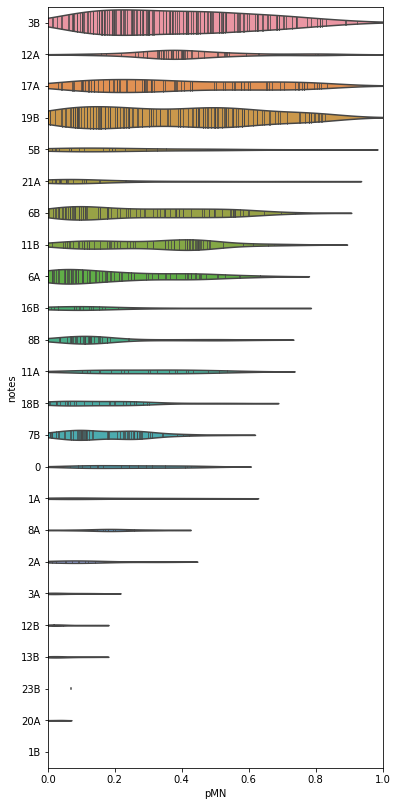

In [324]:
df = counts_syn
# df = df[~df['notes'].str.startswith('u')]
df.iloc[:,0:-3] = df.iloc[:,0:-3].astype(float)
plt.figure(1,figsize = [6,14])

ax = sns.violinplot(y="notes", x="pMN",
                    data=df,
                    scale="count", inner="sticks", orient = "h")

plt.xlim(0,1)                   
plt.show()

In [348]:
proportion_IDs = proportion_mn_df.merge(premotor_df, how = 'inner')
proportion_IDs.head()

,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref,class,notes,notes1
0,648518346494696355,243,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM,local,3B,3B?
1,648518346517344554,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt,local,NaN,11?
2,648518346489656701,1274,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx,local,NaN,u3
3,648518346499338078,69,0.0,0.347826,0.0,0.521739,0.043478,0.0,0.086957,0.0,0.0,firstAx,local,NaN,u1D
4,648518346487473834,48,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM,local,NaN,u2M


In [455]:
# horizontal bars of number of pmns that prefer a sclerite type for each hemilineage
pmn_list = premotor_df[premotor_df.notes.isin(['21A'])]
pmn_df = proportion_IDs[proportion_IDs.SegID.isin(pmn_list.SegID.to_list())]
pmn_counts = pmn_df.pref.value_counts()

In [456]:
pmn_counts

tp_tt    27
Name: pref, dtype: int64

In [457]:
pmn_counts['DLM'] = 0
pmn_counts['DVM'] = 0

pmn_counts['basalar'] = 0
pmn_counts['firstAx'] = 0
pmn_counts['thirdAx'] = 0
pmn_counts['hg'] = 0

# pmn_counts['tp_tt'] = 0
pmn_counts['PS'] = 0
pmn_counts['unknown'] = 0

In [458]:
pmn21A_counts = pmn_counts

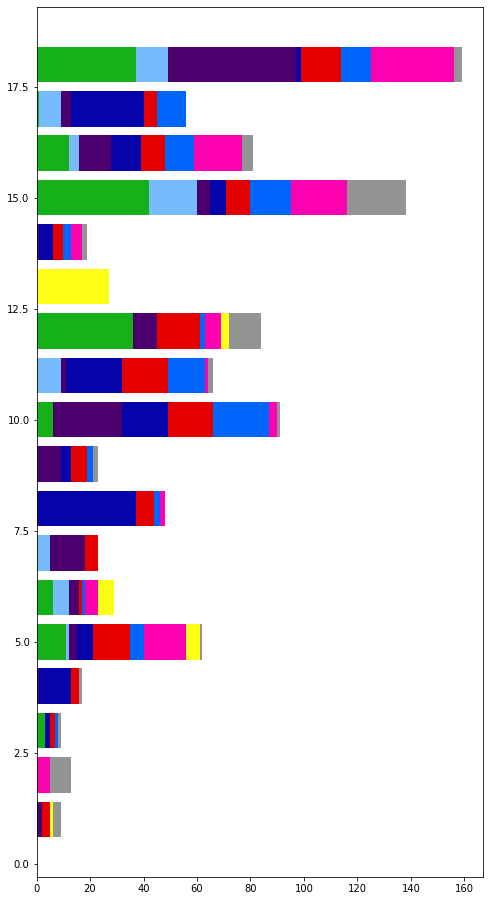

In [460]:
colors = ["#15b01a", "#75bbfd","#4b006e","#0504aa","#e50000","#0165fc","#fe01b1", "#ffff14", "#929591"]
# colors = ["#929591", "#ffff14","#fe01b1","#0165fc","#e50000","#0504aa","#4b006e", "#75bbfd", "#15b01a"] # reversed
cmap = sns.set_palette(sns.color_palette(colors))

plt.figure(1,figsize = [8,16])

plot_barh_sc(pmn2A_counts,1)
plot_barh_sc(pmn8A_counts,2)
plot_barh_sc(pmn1A_counts,3)
plot_barh_sc(pmn0_counts,4)
plot_barh_sc(pmn7B_counts,5)
plot_barh_sc(pmn18B_counts,6)
plot_barh_sc(pmn11A_counts,7)
plot_barh_sc(pmn8B_counts,8)
plot_barh_sc(pmn16B_counts,9)
plot_barh_sc(pmn6A_counts,10)
plot_barh_sc(pmn11B_counts,11)
plot_barh_sc(pmn6B_counts,12)
plot_barh_sc(pmn21A_counts,13)
plot_barh_sc(pmn5B_counts,14)
plot_barh_sc(pmn19B_counts,15)
plot_barh_sc(pmn17A_counts,16)
plot_barh_sc(pmn12A_counts,17)
plot_barh_sc(pmn3B_counts,18)


plt.show()

In [390]:
def plot_barh_sc(df,xn1):
    plt.barh(xn1, df['DLM'])
    plt.barh(xn1, df['DVM'], left = df['DLM'])
    plt.barh(xn1, df['basalar'], left = df['DVM'] + df['DLM'])
    plt.barh(xn1, df['firstAx'], left = df['basalar'] + df['DVM'] + df['DLM'])
    plt.barh(xn1, df['thirdAx'], left = df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
    plt.barh(xn1, df['hg'], left = df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
    plt.barh(xn1, df['PS'], left = df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
    plt.barh(xn1, df['tp_tt'], left = df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
    plt.barh(xn1, df['unknown'], left = df['tp_tt'] + df['PS'] + df['hg'] + df['thirdAx'] + df['firstAx'] + df['basalar'] + df['DVM'] + df['DLM'])
    

In [327]:
pmn19B_list = premotor_df[premotor_df.notes.isin(['19B'])]
# pmn19B_df = synapse_df[synapse_df.pre_pt_root_id.isin(pmn3B_list.SegID.to_list())]
len(pmn19B_list)

141

In [328]:
# Designate which neuron(s) to query
# output if segIDs have no partners - means the ID is out of date

thresh_syn = 3 # minimum synapse threshold to be considered a partner
prepost = "pre" # "pre" to find presynaptic partners, "post" to find postsynaptic partners
query_list = pmn19B_list.SegID.to_list()

syn3b_df = ut.build_synapse_df(query_list,prepost,thresh_syn,client) 
postcounts = pd.DataFrame(syn3b_df['post_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))
precounts = pd.DataFrame(syn3b_df['pre_pt_root_id'].value_counts().rename_axis('SegID').reset_index(name='counts'))

synapse3b_df = syn3b_df[~syn3b_df.pre_pt_root_id.isin(twigIDs.SegID.to_list())]

if postcounts.shape[0] != len(query_list):
    print('Warning: The following segIDs are not up to date')
    print(list(set(query_list) - set(postcounts['SegID'])))

[648518346475408820]


In [461]:
proportion_mn_df.head()

,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref
0,648518346494696355,243,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM
1,648518346517344554,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt
2,648518346489656701,1274,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx
3,648518346499338078,69,0.0,0.347826,0.0,0.521739,0.043478,0.0,0.086957,0.0,0.0,firstAx
4,648518346487473834,48,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM


In [477]:
# how strong is are the preferences?
proportion_mn_df['pref_p'] = 0

i = 0
while i < len(proportion_mn_df):
    proportion_mn_df['pref_p'].iloc[i] = max(proportion_mn_df.iloc[i,2:-2])
    i = i+1

proportion_mn_df

/Users/ellenlesser/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,SegID,mn,DLM,DVM,basalar,firstAx,thirdAx,hg,PS,tp_tt,unknown,pref,pref_p
0,648518346494696355,243,0.0,0.847737,0.0,0.0,0.0,0.0,0.0,0.09465,0.020576,DVM,0.847737
1,648518346517344554,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,tp_tt,1.000000
2,648518346489656701,1274,0.0,0.0,0.105181,0.0,0.492936,0.39325,0.008634,0.0,0.0,thirdAx,0.492936
3,648518346499338078,69,0.0,0.347826,0.0,0.521739,0.043478,0.0,0.086957,0.0,0.0,firstAx,0.521739
4,648518346487473834,48,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.4375,0.0625,DVM,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,648518346490370826,25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,firstAx,1.000000
1259,648518346520525622,27,0.0,0.0,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,basalar,0.777778
1260,648518346494443797,35,0.0,0.0,0.771429,0.0,0.0,0.0,0.0,0.0,0.0,basalar,0.771429
1261,648518346472332747,25,0.24,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,basalar,0.600000


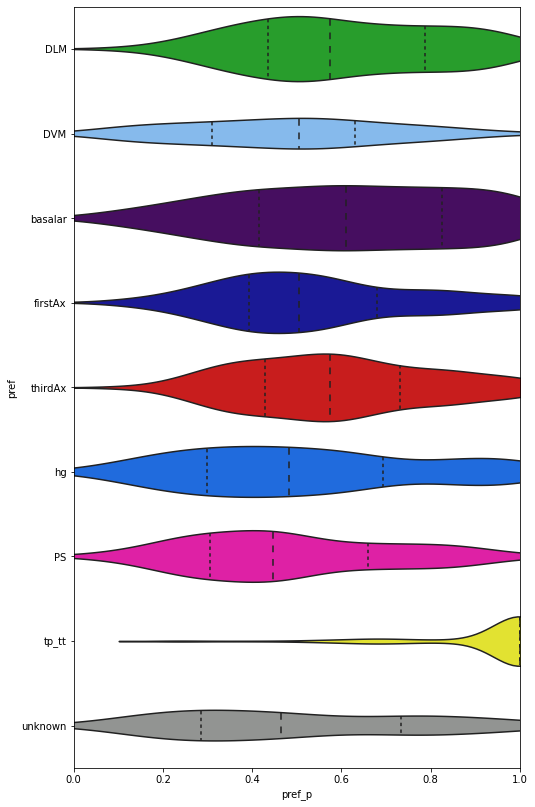

In [481]:
df = proportion_mn_df
# df = df[~df['notes'].str.startswith('u')]
# df.iloc[:,0:-3] = df.iloc[:,0:-3].astype(float)
plt.figure(1,figsize = [8,14])

ax = sns.violinplot(y="pref", x="pref_p",
                    data=df, order=["DLM", "DVM", "basalar", "firstAx", "thirdAx", "hg", "PS", "tp_tt", "unknown"],
                    scale="count", inner="quartile", orient = "h")

plt.xlim(0,1)                   
plt.show()

int

''

TypeError: '>' not supported between instances of 'str' and 'float'